## Import

In [1]:
from datetime import date
from io import BytesIO
import base64
from IPython import display
import model_card_toolkit as mctlib
import uuid

from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style='dark')

## Load data

In [2]:
data = load_breast_cancer()

X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
X_train.shape

(455, 30)

In [5]:
X_test.shape

(114, 30)

In [6]:
def plot_to_str():
    img = BytesIO()
    plt.savefig(img, format='png')
    return base64.encodebytes(img.getvalue()).decode('utf-8')

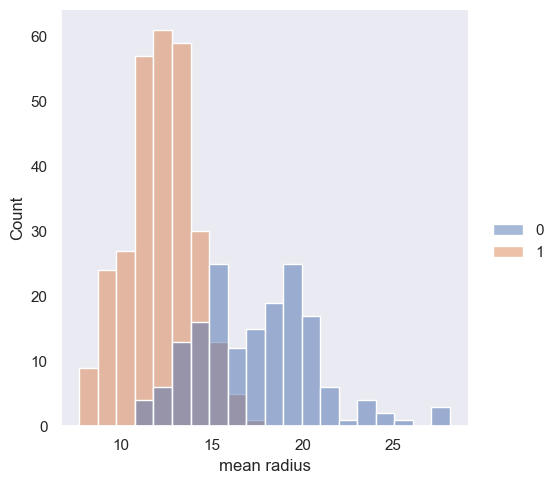

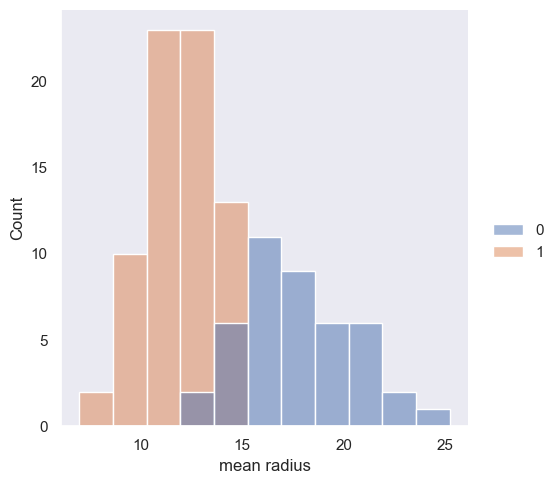

In [7]:
sns.displot(x=X_train['mean radius'], hue=y_train)
mean_radius_train = plot_to_str()

sns.displot(x=X_test['mean radius'], hue=y_test)
mean_radius_test = plot_to_str()

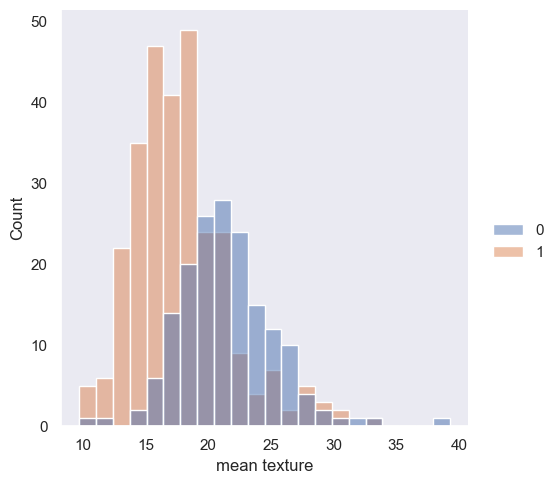

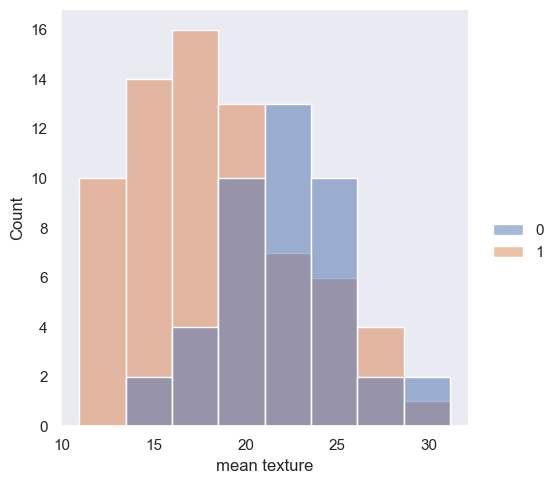

In [8]:
sns.displot(x=X_train['mean texture'], hue=y_train)
mean_texture_train = plot_to_str()

sns.displot(x=X_test['mean texture'], hue=y_test)
mean_texture_test = plot_to_str()

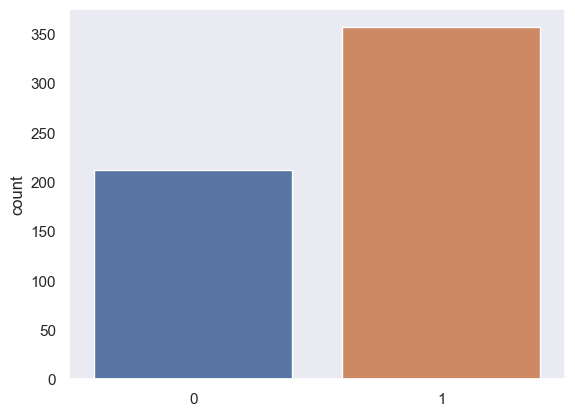

In [9]:
sns.countplot(x=y)
y_count = plot_to_str()

In [10]:
# sns.countplot(x=y_test)
# y_test_count = plot_to_str()

## Train model

In [11]:
scaler = MinMaxScaler()

X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

In [12]:
model = DecisionTreeClassifier().fit(X_train_scaler, y_train)

## Evaluate model

In [13]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_curve, auc

y_pred = model.predict(X_test_scaler)

accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
recall = recall_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred)

print("Accuracy = {}".format(accuracy))
print("Recall = {}".format(recall))
print("Precision = {}".format(precision))

Accuracy = 0.9385964912280702
Recall = 0.9577464788732394
Precision = 0.9444444444444444


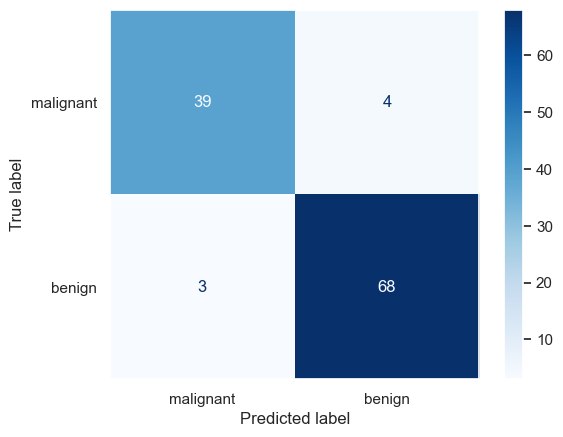

In [14]:
ConfusionMatrixDisplay.from_estimator(
    model,
    X_test_scaler,
    y_test,
    display_labels=data.target_names,
    cmap=plt.cm.Blues,
    normalize=None,
)
confusion_matrix = plot_to_str()

In [15]:
# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# roc_auc = auc(fpr, tpr)

# display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
# display.plot()
# roc_curve_ = plot_to_str()


## Create a model card

In [51]:
mct = mctlib.ModelCardToolkit(output_dir="./model_card")

model_card = mct.scaffold_assets()

In [52]:
# Model details

model_card.model_details.name = 'Breast Cancer Wisconsin (Diagnostic) Dataset'
model_card.model_details.overview = (
    'This model predicts whether breast cancer is benign or malignant based on '
    'image measurements.')
model_card.model_details.owners = [
    mctlib.Owner(name= 'Fajri', contact='fajri@dicoding.com')
]
model_card.model_details.references = [
    mctlib.Reference(reference='https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)'),
    mctlib.Reference(reference='https://minds.wisconsin.edu/bitstream/handle/1793/59692/TR1131.pdf')
]
model_card.model_details.version.name = str(uuid.uuid4())
model_card.model_details.version.date = str(date.today())

# Model considerations

model_card.considerations.ethical_considerations = [mctlib.Risk(
    name=('Manual selection of image sections to digitize could create '
            'selection bias'),
    mitigation_strategy='Automate the selection process'
)]
model_card.considerations.limitations = [mctlib.Limitation(description='Breast cancer diagnosis')]
model_card.considerations.use_cases = [mctlib.UseCase(description='Breast cancer diagnosis')]
model_card.considerations.users = [mctlib.User(description='Medical professionals'), mctlib.User(description='ML researchers')]

# Model parameters

model_card.model_parameters.data.append(mctlib.Dataset())
model_card.model_parameters.data[0].graphics.collection = [
    mctlib.Graphic(image=y_count)
]

model_card.model_parameters.data.append(mctlib.Dataset())
model_card.model_parameters.data[1].graphics.description = (
  f'{len(X_train)} rows with {len(X_train.columns)} features')
model_card.model_parameters.data[1].graphics.collection = [
    mctlib.Graphic(image=mean_radius_train),
    mctlib.Graphic(image=mean_texture_train),
]

model_card.model_parameters.data.append(mctlib.Dataset())
model_card.model_parameters.data[2].graphics.description = (
  f'{len(X_test)} rows with {len(X_test.columns)} features')
model_card.model_parameters.data[2].graphics.collection = [
    mctlib.Graphic(image=mean_radius_test),
    mctlib.Graphic(image=mean_texture_test),
]


# Model quantitative analysis
model_card.quantitative_analysis.graphics.description = (
  'Confusion matrix')
model_card.quantitative_analysis.graphics.collection = [
    mctlib.Graphic(image=confusion_matrix)
]
# model_card.quantitative_analysis.performance_metrics = [
#     mctlib.PerformanceMetric(type='accuracy', value=str(accuracy)),
#     mctlib.PerformanceMetric(type='recall', value=str(recall)),
#     mctlib.PerformanceMetric(type='precision', value=str(precision)),
# ]

mct.update_model_card(model_card)

In [53]:
# Return the model card document as an HTML page

html = mct.export_format()

display.display(display.HTML(html))